# Supervising the encoder using the Poisson equation

Here is a demonstration on how to train the encoder to learn the parameters $\Theta$ of
a partial differential equation (PDE) given observations of the solution $u_\Theta$.
Now, technically for this procedure we don't actually need $u_\Theta$ to be the solution of a PDE,
it just needs to be some family of functions parameterized by $\Theta$.
But we will consider the PDE setting, as it is the desired usage of the autoencoder.

To that end, let $\Theta = (u_0, u_1, c)$ be (constant) parameters for the Poisson equation
with Dirichlet boundary conditions on the unit interval. That is, $u_\Theta$ is the solution to

$$
\begin{align*}
    -\nabla u &= c \quad\text{on  } [0,1] \\
    u(0) &= u_0 \\
    u(1) &= u_1
\end{align*}
$$

Since $c$ is constant, this equation is readily solved for $u_\Theta = u(x)$ as the family of parabolas

$$ 
    u(x) = -\frac{c}{2} x^2 + \left( \frac{c}{2} + u_1 - u_0 \right) x + u_0 
$$

Now we will walk through training the encoder in four main steps:
1. Write the configuration file
2. Load the data
3. Design the neural network
4. Train the network

## 1. Configuration file
Now to train the encoder to learn $\Theta$ in this setup, we simply create a Python script `equations/poisson.py`
which contains the implementations of functions that define the domain, compute replicates of $\Theta$,
compute $u_\Theta$ for a given replicate, and a list of parameter names (optional). 
Let's briefly walk through the Poisson configuration file.

### Parameter names
First we import `numpy` and create a list containing strings to name the parameters in $\Theta$.
In this case the names are $u_0$, $u_1$, and $c$.
The strings may be formatted with `matplotlib`'s TeX rendering syntax.

In [1]:
import numpy as np 

# PARAMETER NAMES
Theta_names = [r'$u_0$', r'$u_1$', r'$c$']

### Domain lattice
Next we write a quick function that computes a lattice over the domain,
in this case the unit interval.

In [2]:
# DOMAIN
def domain():
    """
    The unit interval as an array of length 100
    """
    dom = np.linspace(0., 1., num=100)
    return dom

### Solution $u_\Theta$
Now we write a function that takes $\Theta$ as the input,
and computes the solution function $u_\Theta = u(x)$ over
the lattice defined above.
This should be written assuming the argument `Theta` is 
a one-dimensional numpy array that contains the parameter values.

In [3]:
# SOLUTION
def solution(Theta):
    """
    Computes the solution u where Theta=[u0, u1, c]
    """
    x = domain()
    u0 = Theta[0]
    u1 = Theta[1]
    c = Theta[2]
    u = -c * x**2 / 2 + (c/2 + u1 - u0)*x + u0
    return u

### Priors on $\Theta$
Now to simulate replicates of our parameters,
we draw from uniform distributions and stack the arrays
so that the output has shape `(replicates, num_params)`.

In [4]:
# THETA
def Theta(replicates):
    """
    Simulates replicates of Theta
    Output has shape (replicates, num_params)
    """
    # create replicates of Theta=[u0,u1,c]
    u0 = np.random.uniform(-10,10, size=replicates)
    u1 = np.random.uniform(-10,10, size=replicates)
    c = np.random.uniform(-100,100, size=replicates)
    Theta = np.stack((u0, u1, c), axis=1)
    return Theta

With `equations/poisson.py` properly configured we need only run
`python train_encoder.py --trainon poisson`.
The file `train_encoder.py` has three main parts to it: 
load data, define neural network hyperparameters, train model.
Instead of running this script, let's run it in this notebook
to break it down.

## 2. Load data
The modules loaded in `train_encoder.py` are in the `autoencoder.supervise` package.
We load (and possibly simulate) data using the `equation.Dataset` class,
which simply needs the name of the configuration file, excluding the file suffix.

In [5]:
from autoencoder.supervise import equation

# LOAD DATA
dataset = equation.Dataset('poisson')
dataset.load()

The data are now loaded into the Dataset instance `dataset`,
already split into a training, validation, and test set.
It loads the data from the pickled file `data/poisson.pkl`,
but if the file doesn't exist the data are simulated
according to the configuration file using a default of 2000 replicates.
The parameter names and functions defined in the configuration file
are stored in the `dataset.Eqn` class.
We can use this to explore the data before designing the network.
Observe, we'll plot $u_\Theta = u(x)$ for two realizations of $\Theta$,
with the parameter values in the titles.

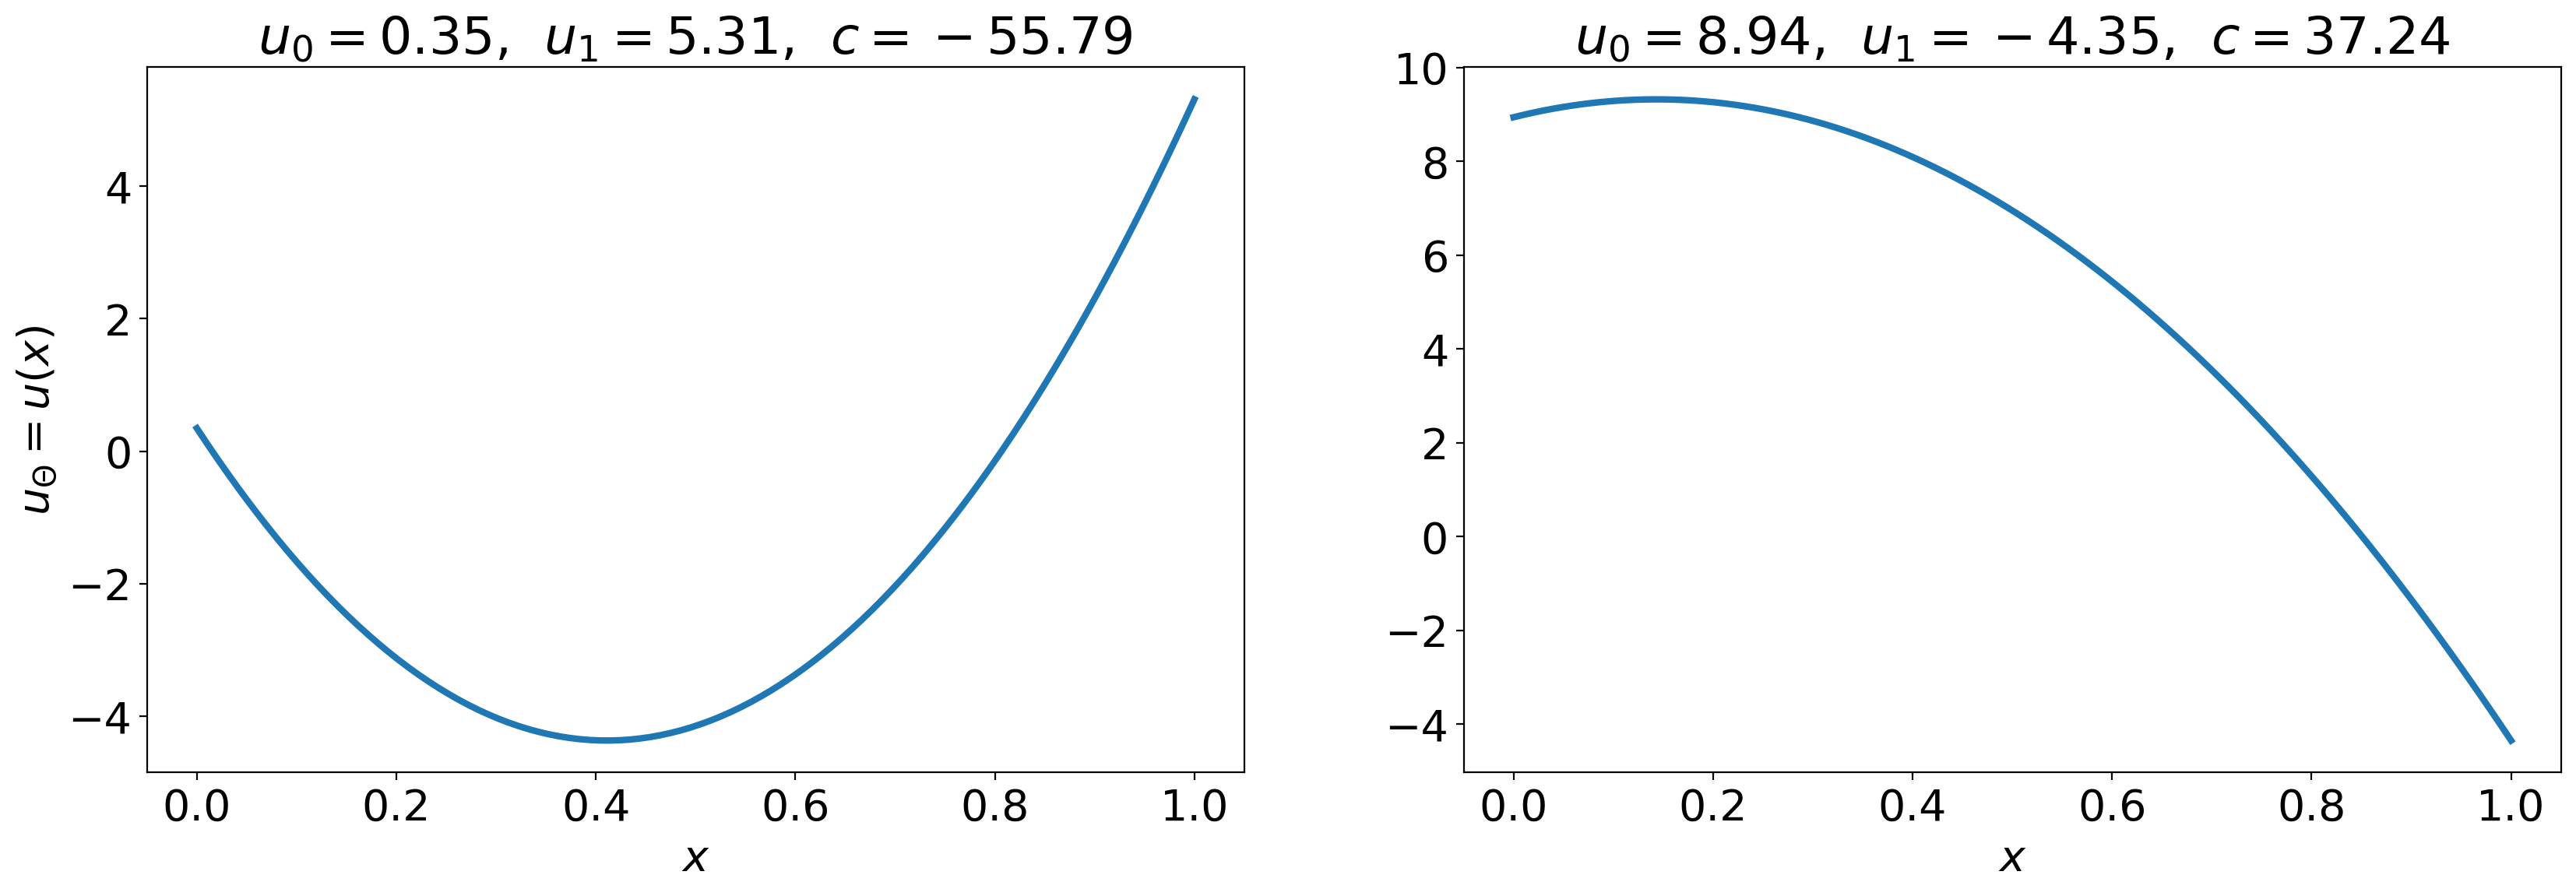

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

# get the domain and simulate two realizations of Theta
np.random.seed(23)
domain = dataset.Eqn.domain()
replicates = 2
Theta = dataset.Eqn.Theta(replicates)

# compute u_Theta = u(x)
num_params = Theta.shape[1]
u = np.zeros((replicates, len(domain)))

for idx, theta in enumerate(Theta):
    u[idx] = dataset.Eqn.solution(theta)
    
names = tuple(dataset.Eqn.Theta_names)
commas = [',  ', ',  ', '']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6), dpi=200)
for i in range(2):
    title = ''
    for j, name in enumerate(names):
        title += r'%s' % names[j] + r'$= %.2f$' % Theta[i,j] + commas[j]
    ax[i].plot(domain, u[i], linewidth=3)
    ax[i].set_xlabel(r'$x$')
    ax[i].set_title(title)
ax[0].set_ylabel(r'$u_\Theta = u(x)$')

plt.show(fig)
plt.close(fig)

Indeed, we can confirm the left and right endpoints 
of the above curves are given by $u_0$ and $u_1$, respectively.
Furthermore, the parameter $c$ measures the negative curvature
of the solutions, as is evident from the Poisson equation.

## 3. Design the neural net

Now that the data are loaded, we can design a neural network to train.
We will construct a feed-forward network with two hidden layers
containing 100 and 50 nodes, respectively. 
By default the data are rescaled to be in the intervale $[-1, 1]$,
so $\tanh$ activations are a natural choice. Since this is a regression
task, the final layer will be activated with the identity function $f(x) = x$.
To avoid overfitting we'll drop 10% of the units at each layer.
The optimizer and loss will be Adam and mean square error, respectively.
Let's train the network for 10 epochs using batch sizes of 25.

Conveniently, this is all recorded in a design dictionary below. 
Most keys make intuitive sense, but the `unit_activations` key
is perhaps more cryptic. It is a list of tuples, each tuple represents
the number of units and activation for each layer (in this case 4 layers).
We'll leave the callbacks list empty for now, but if we were training longer
we might decide to use a learning rate schedule or Tensorboard callbacks.

In [7]:
in_units = dataset.train[0].shape[1]
out_units = dataset.train[1].shape[1]

## DEFINE MODEL PARAMETERS
design = {'flavor':'ff',
          'unit_activations':[(in_units, 'tanh'),
                              (100, 'tanh'),
                              (50, 'tanh'),
                              (out_units, 'linear')
                             ],
          'dropout':[0.1, 0.1, 0.1],
          'optimizer':'adam',
          'loss':'mse',
          'callbacks':[],
          'batch_size':25,
          'epochs':10,
         }

## 4. Train!

All that is left is to train the encoder.
We use the `autoencoder.supervise.encoder.Encoder` class,
which inherits from `tensorflow.keras.models.Sequential`.
For reproducible results we'll set a seed in Tensorflow 
before training.

In [8]:
from autoencoder.supervise import encoder
from tensorflow.random import set_seed
set_seed(23)

# TRAIN MODEL
model = encoder.Encoder(design, dataset)
model.train()

Epoch 1/10
48/48 - 0s - loss: 0.0494 - val_loss: 0.0056
Epoch 2/10
48/48 - 0s - loss: 0.0021 - val_loss: 0.0027
Epoch 3/10
48/48 - 0s - loss: 0.0010 - val_loss: 0.0025
Epoch 4/10
48/48 - 0s - loss: 7.9115e-04 - val_loss: 0.0023
Epoch 5/10
48/48 - 0s - loss: 5.4546e-04 - val_loss: 0.0014
Epoch 6/10
48/48 - 0s - loss: 5.5509e-04 - val_loss: 0.0030
Epoch 7/10
48/48 - 0s - loss: 5.0930e-04 - val_loss: 9.7314e-04
Epoch 8/10
48/48 - 0s - loss: 3.7509e-04 - val_loss: 9.7368e-04
Epoch 9/10
48/48 - 0s - loss: 3.8707e-04 - val_loss: 0.0025
Epoch 10/10
48/48 - 0s - loss: 3.8317e-04 - val_loss: 6.5921e-04


Great, training complete! Now let's see how the network performs
when predicting on a test set.

test loss: 0.00042317871702834964


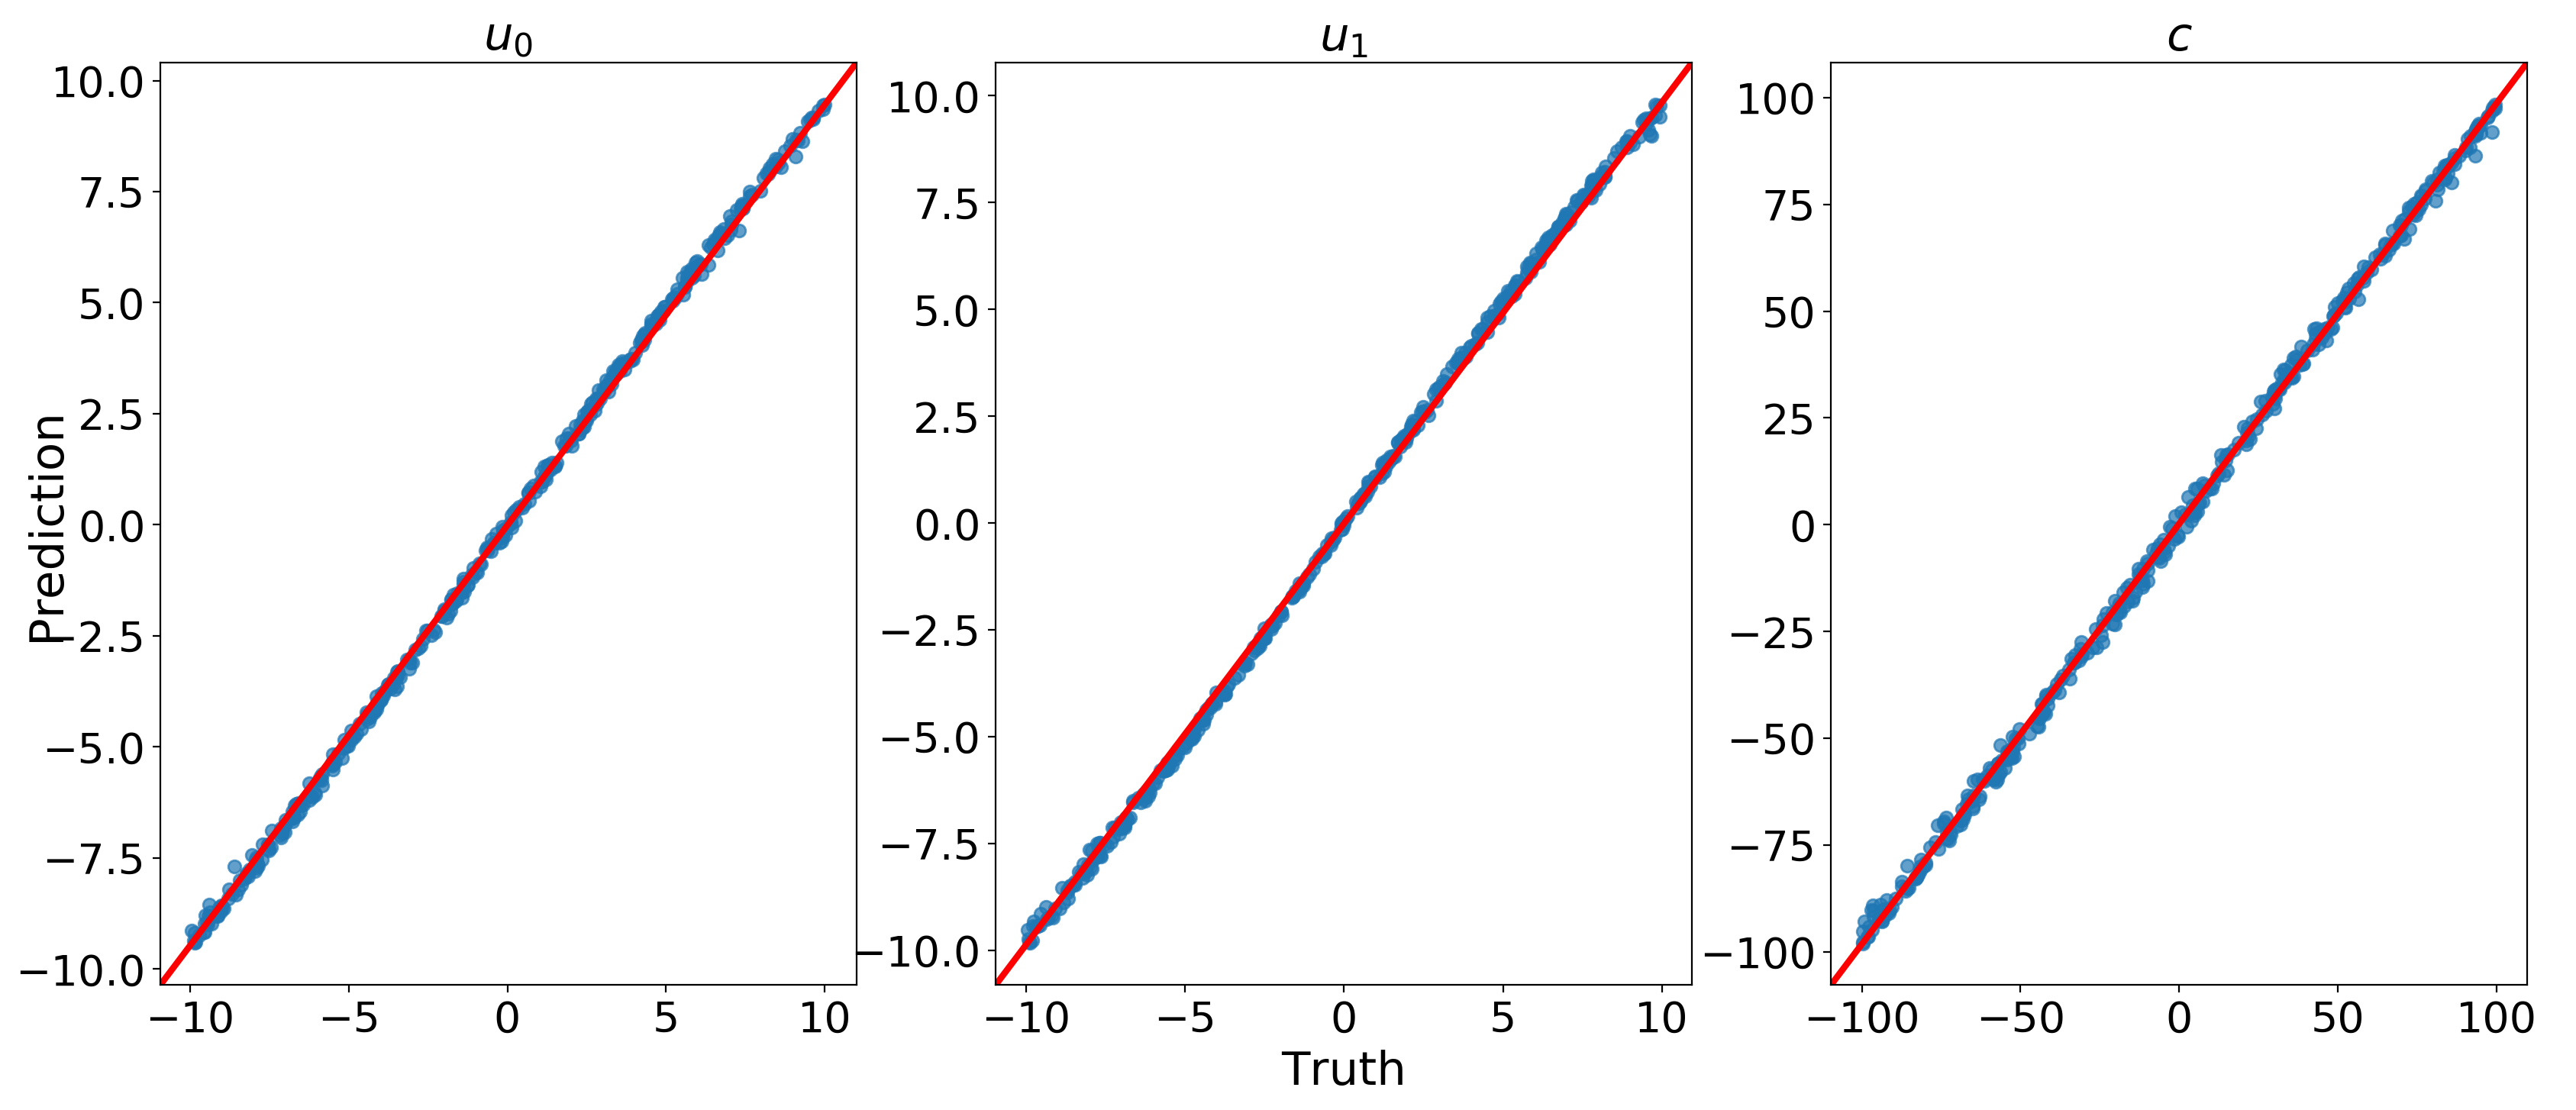

In [9]:
model.predict_plot(here=True)

Not too shabby. You can find the above plot in the directory 
denoted by the date and time during training, contained in `logs/fit/`. 
There is also the same plot but with the transformed data that were
used during training, if you wish to see that as well.